Load Libraries

In [58]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

#!pip install dython

from dython.nominal import associations
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

#!pip install kneed #Correct the typo in pip install command
from kneed import KneeLocator #Import KneeLocator class

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

Load Data

In [59]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
Nba_data = pd.read_csv(url, encoding='utf-8')

Checking Data

In [60]:
Nba_data.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


Drop Unnecessary columns (run code, then comment when encounter an eror)

In [61]:
Nba_data = Nba_data.drop(columns=['game_id', 'team_id', 'season'])

Check Data

In [62]:
Nba_data

,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55309,Pacers,IND,pacers,265:00,45.0,112.0,0.402,13.0,53.0,0.245,...,0.0,0.402,0.0,0.0,0.0,127.0,0,0,0,0
55310,Suns,PHX,suns,265:00,42.0,95.0,0.442,14.0,37.0,0.378,...,0.0,0.442,0.0,0.0,0.0,126.0,0,1,0,0
55311,Timberwolves,MIN,timberwolves,240:00,39.0,90.0,0.433,14.0,31.0,0.452,...,0.0,0.433,0.0,0.0,0.0,96.0,0,1,0,0
55312,Lakers,LAL,lakers,207:10,34.0,85.0,0.400,12.0,32.0,0.375,...,0.0,0.410,0.0,0.0,0.0,103.0,0,0,0,0


Instead of points as the dependent variable. Lets try the field goal percentage column. Reason: Field goals count as all shots attempted.

Detecting missing values.
new_data is filtering the DataFrame Nba_data to remove rows where the points column has missing (NaN) values.

In [63]:
#Can drop because its a small percentage of data
def show_missing_vals(df:pd.DataFrame)->pd.DataFrame:
    return Nba_data.isna().sum().divide(len(Nba_data)).sort_values(ascending=False)

print(show_missing_vals(Nba_data))

#Cleaned data stored in a variable
cleaned_Nba_data = Nba_data.dropna()

cleaned_Nba_data.isna().sum().sum()

estimated_team_turnover_percentage    0.036971
defensive_rebound_percentage          0.036971
estimated_defensive_rating            0.036971
defensive_rating                      0.036971
estimated_net_rating                  0.036971
                                        ...   
points                                0.000488
is_home_team                          0.000000
won_game                              0.000000
is_playoff_game                       0.000000
is_regular_game                       0.000000
Length: 69, dtype: float64


0

Check Data

In [64]:
cleaned_Nba_data['field_goals_percentage'] = cleaned_Nba_data['field_goals_percentage'].astype(float)
cleaned_Nba_data.head()

<ipython-input-64-3c48f0c7323c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_Nba_data['field_goals_percentage'] = cleaned_Nba_data['field_goals_percentage'].astype(float)


,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


Removing Highly Correlated Variables

In [65]:
#Create a function to remove highly correlated values from the data
def removeHighCorr (data,dep_var,thresh):
  corr_matrix=associations(dataset=data.drop(dep_var,axis=1), compute_only=True)['corr'].abs()
  upper_tri=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
  to_drop=[column for column in upper_tri.columns if any(upper_tri[column]>thresh)]
  new_data=data.drop(to_drop,axis=1)
  return new_data

nba_no_high_corr = removeHighCorr(cleaned_Nba_data,'field_goals_percentage',0.7)

Remove near zero variance

In [66]:
#Before applying VarianceThreshold, select only numerical features
numerical_features = nba_no_high_corr.select_dtypes(include=np.number).columns
nba_no_high_corr_numeric = nba_no_high_corr[numerical_features]

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(nba_no_high_corr_numeric)

vars = nba_no_high_corr_numeric.columns[vThreshold.get_support()]

nba_no_high_corr_nzv_df = nba_no_high_corr[vars] #New data from scrubing #Nzv near zero variance
nba_no_high_corr_nzv_df.head()

,field_goals_made,field_goals_attempted,three_pointers_made,free_throws_made,rebounds_offensive,rebounds_defensive,steals,blocks,turnovers,fouls_personal,plus_minus_points,estimated_defensive_rating,estimated_pace,distance,free_throw_assists,is_home_team
0,29.0,68.0,7.0,16.0,8.0,30.0,4.0,7.0,13.0,20.0,7.0,91.2,81.26,0.0,0.0,1
1,31.0,75.0,8.0,16.0,13.0,30.0,3.0,2.0,11.0,18.0,-9.0,119.7,82.40,0.0,0.0,1
2,37.0,84.0,2.0,19.0,16.0,26.0,7.0,11.0,11.0,20.0,-1.0,107.6,81.22,0.0,0.0,1
3,41.0,90.0,2.0,18.0,13.0,34.0,13.0,6.0,3.0,22.0,31.0,82.0,88.84,0.0,0.0,1
4,40.0,85.0,3.0,13.0,17.0,27.0,12.0,10.0,11.0,18.0,17.0,94.3,85.64,0.0,0.0,1


Standardize Data

In [67]:
#Standardizing Data
Nba_data_std = StandardScaler().fit_transform(nba_no_high_corr_nzv_df)
Nba_data_std = pd.DataFrame(Nba_data_std, columns = nba_no_high_corr_nzv_df.columns)
Nba_data_std.head()

,field_goals_made,field_goals_attempted,three_pointers_made,free_throws_made,rebounds_offensive,rebounds_defensive,steals,blocks,turnovers,fouls_personal,plus_minus_points,estimated_defensive_rating,estimated_pace,distance,free_throw_assists,is_home_team
0,-1.688024,-1.951035,-0.418791,-0.331954,-0.691655,-0.387194,-1.212068,0.850612,-0.174455,-0.154191,0.497375,-1.238241,-2.590970,-1.056995,-0.688657,1.0
1,-1.330066,-1.096312,-0.186676,-0.331954,0.593169,-0.387194,-1.555078,-1.121900,-0.684412,-0.596716,-0.639976,1.178014,-2.407925,-1.056995,-0.688657,1.0
2,-0.256192,0.002618,-1.579369,0.151908,1.364063,-1.103442,-0.183040,2.428622,-0.684412,-0.154191,-0.071301,0.152165,-2.597392,-1.056995,-0.688657,1.0
3,0.459724,0.735238,-1.579369,-0.009379,0.593169,0.329055,1.875018,0.456110,-2.724236,0.288333,2.203401,-2.018225,-1.373882,-1.056995,-0.688657,1.0
4,0.280745,0.124722,-1.347254,-0.815815,1.621027,-0.924380,1.532008,2.034120,-0.684412,-0.596716,1.208219,-0.975420,-1.887692,-1.056995,-0.688657,1.0


Apply PCA

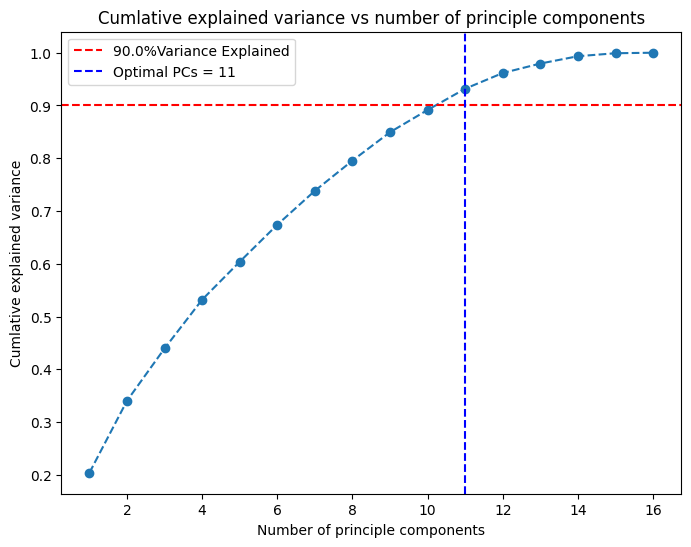

In [68]:
#Apply PCA without specifying the number of components
pca = PCA()
pca.fit(Nba_data_std)

#Compute explained variance
explained_variance = pca.explained_variance_ratio_
cumlative_variance = np.cumsum(explained_variance)
#explained_variance
cumlative_variance


#Find number of components that explains at least some threshold of variance
threshold = 0.9
n_components_thresh = np.argmax(cumlative_variance >= threshold) + 1
n_components_thresh

#Plot cumlative explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1,len(cumlative_variance)+1), cumlative_variance, marker='o', linestyle="--")
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}%Variance Explained')
plt.axvline(x=n_components_thresh, color='b', linestyle='--', label=f'Optimal PCs = {n_components_thresh}')
plt.xlabel("Number of principle components")
plt.ylabel("Cumlative explained variance")
plt.title("Cumlative explained variance vs number of principle components")
plt.legend()

Elbow Method

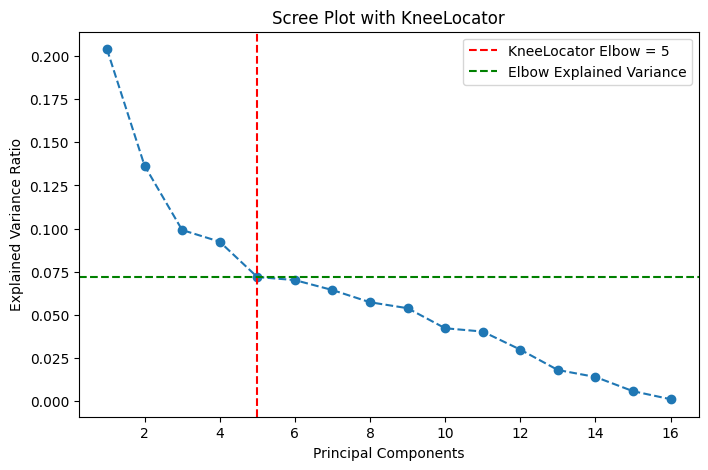

In [69]:
# Find the elbow point mathemetically
knee_locator = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, curve='convex', direction='decreasing')
scree_components = knee_locator.knee

# scree plot with knee locator
plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained_variance ) + 1), explained_variance, marker='o', linestyle='--')
plt.axvline(x=scree_components, color='r', linestyle='--', label=f'KneeLocator Elbow = {scree_components}')
plt.axhline(y=explained_variance[scree_components-1], color='g', linestyle='--', label=f'Elbow Explained Variance')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot with KneeLocator")
plt.legend()
plt.show()

Compare cumulative explained variance for both methods

In [70]:
# compare cumulative explained variance for both methods
exp_varScree = np.sum(explained_variance[:scree_components])
exp_varThresh = np.sum(explained_variance[:n_components_thresh])

print(f"Percentage of variance explained by {scree_components} components: {exp_varScree:.2%}")
print(f"Percentage of variance explained by {n_components_thresh} components: {exp_varThresh:.2%}")

Percentage of variance explained by 5 components: 60.40%
Percentage of variance explained by 11 components: 93.18%


Converting PCA's to a Data Frame

In [71]:
# Conduct PCA using optimal number of components
pca = PCA(n_components=n_components_thresh)
Nba_Data_pca = pca.fit_transform(Nba_data_std)

# Convert PCA results to dataframe
NBA_Data_pca_df = pd.DataFrame(Nba_Data_pca, columns=[f'PC{i+1}' for i in range(Nba_Data_pca.shape[1])])
NBA_Data_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-3.205048,-1.821344,-1.260328,-1.723797,0.268618,-0.636589,-0.287180,0.599143,0.272671,1.190394,-0.019310
1,-2.901401,1.048440,-1.824022,-0.652116,0.799066,-0.992872,-0.268563,0.609672,-1.228376,0.425694,-0.424185
2,-2.423145,-0.794187,-1.650970,1.346659,1.013834,-1.373246,0.406970,0.895583,2.092271,0.890743,-0.372794
3,-0.448782,-3.140709,-2.475742,1.794326,1.468299,0.875833,1.150166,-1.028976,0.591711,0.160895,1.716846
4,-1.280436,-2.156048,-2.094499,1.969791,0.170596,-0.044404,1.478405,0.633812,1.679944,1.082690,-0.343470
...,...,...,...,...,...,...,...,...,...,...,...
53253,2.976178,-0.828224,0.876793,3.310190,-1.653433,-0.989733,-0.676732,0.116766,1.656481,-1.756108,-0.664612
53254,1.252620,-0.477753,2.378845,1.444213,0.464356,0.495529,-1.685159,-0.728529,-0.646050,-1.387748,-0.894273
53255,0.959205,-1.551262,0.753518,1.464418,-1.925733,0.379908,-0.778673,-0.109365,0.659317,0.312797,-0.594041
53256,0.375725,0.937206,0.399986,0.269938,-2.351050,0.612425,0.056495,0.512477,0.435134,-1.853276,-0.120608


Display the loadings of each variable in each PC

In [72]:
var_names = nba_no_high_corr_nzv_df.columns
housing_loadings = pd.DataFrame(pca.components_.T, index=var_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
housing_loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
field_goals_made,0.395854,-0.002185,-0.203823,0.183959,0.077995,0.288406,-0.291199,0.114457,0.024977,-0.077076,-0.171891
field_goals_attempted,0.381535,0.142578,-0.139463,0.467761,-0.066293,-0.158941,0.006745,-0.060019,0.001898,-0.121530,0.228970
three_pointers_made,0.385691,0.087259,-0.051756,-0.173546,0.005743,0.205157,-0.199402,0.075355,-0.053005,0.241957,-0.343220
free_throws_made,-0.064971,-0.093785,0.411209,-0.015729,0.668468,-0.041993,0.059307,-0.188746,0.043439,-0.364718,-0.235765
rebounds_offensive,0.009990,0.020883,-0.063901,0.610466,0.100522,-0.434599,0.200784,-0.117930,-0.154008,0.252944,-0.364873


Compute absolute loadings

In [73]:
# Compute absolute loadings
abs_loadings = np.abs(pca.components_)

# compute median loading across all PCs
median_loadings =  np.median(abs_loadings)

# identify important variables (those loadings that exceed the median loading)
important_vars = np.any(abs_loadings > median_loadings, axis=0)

# extract var names
important_features = np.array(var_names)[important_vars]
#important_features

important_features

array(['field_goals_made', 'field_goals_attempted', 'three_pointers_made',
       'free_throws_made', 'rebounds_offensive', 'rebounds_defensive',
       'steals', 'blocks', 'turnovers', 'fouls_personal',
       'plus_minus_points', 'estimated_defensive_rating',
       'estimated_pace', 'distance', 'free_throw_assists', 'is_home_team'],
      dtype=object)

Data partioning, partition the data such that 80% is used for training and 20%

In [74]:
#dep_variable = Nba_data_std['points']
#ind_variable = Nba_data_std.loc[:, Nba_data_std.columns != 'points']

dep_variable = Nba_data_std['turnovers']
ind_variable = Nba_data_std.loc[:, Nba_data_std.columns != 'turnovers']

train_x, test_x, train_y, test_y = train_test_split(ind_variable, dep_variable, test_size=0.2, random_state=2142)

modle fitting results

In [ ]:
#Add intercept term into the data before modeling
train_X = sm.add_constant(train_x)
#Model with training data
model = sm.OLS(train_y, train_X).fit()
#print model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              turnovers   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     5520.
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:38:10   Log-Likelihood:                -37425.
No. Observations:               42606   AIC:                         7.488e+04
Df Residuals:                   42590   BIC:                         7.502e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               